Brief description of the problem and data (5 pts)

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 


The project here we are trying to classify tweets and if they are talking about a real diaster (1) or not a disaster (0) through natural language processing and giving it a binary determination. NLP require us to take human language and classify them so we can build a model around that and to learn from it. 

The data given to us are tweets which are text and labels, labeled for training data, and unlabeled for testing data. Our training set has around 7,500 rows and our test data has around 3000 rows. The training data has columns that have id, keyword, location, text, and target (0 or 1), while testing is just unlabelled data. 


Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

In [98]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from itertools import product
from sklearn.metrics import f1_score




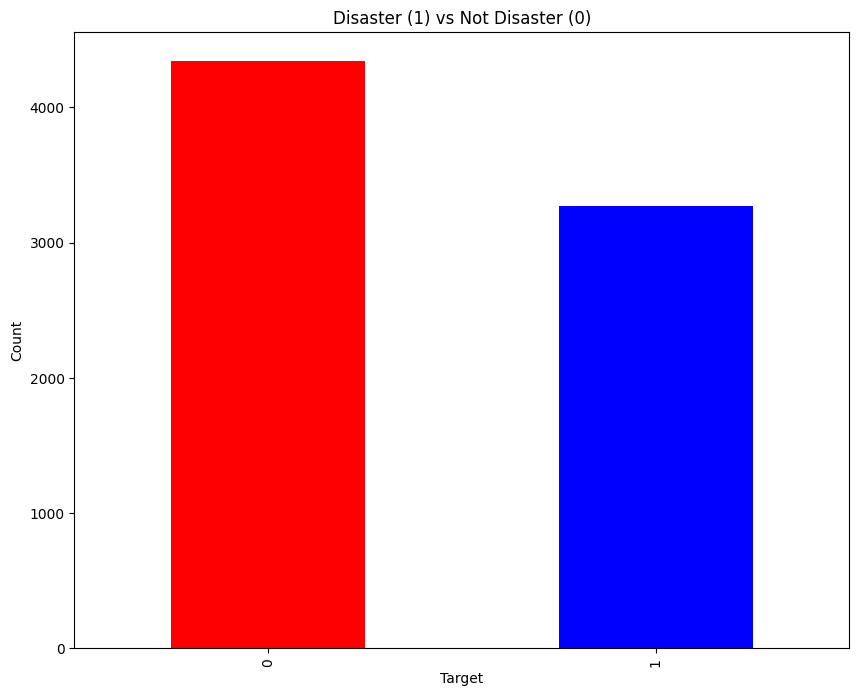

In [99]:
training = pd.read_csv("train.csv")
testing = pd.read_csv("test.csv")
training.head()

plt.figure(figsize=(10,8))
training["target"].value_counts().plot(kind='bar', color=["red","blue"])
plt.title("Disaster (1) vs Not Disaster (0)")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

This shows that we have a good amount of disater and non disaster tweets that will give us a good result when we train with the training data

In [100]:
def cleaning_text(txt):
    # everything lower case
    txt = txt.lower()
    # remove puntuation
    txt = re.sub(r"[^a-z0-9\s]", " ", txt) 
    # remove extra whitespace
    txt = re.sub(r"\s+", " ", txt).strip()
    # remove url
    txt = re.sub(r"http\S+|www\S+|https\S+", "", txt)
    # remove http
    txt = re.sub(r"http\S*", "", txt)
    # remove HTML
    txt = re.sub(r"&\w+;", " ", txt)
    
    return txt


training["clean_text"] = training["text"].astype(str).apply(cleaning_text)
testing["clean_text"] = testing["text"].astype(str).apply(cleaning_text)


I cleaned up the data by making the data all lowercase, no punctation, and no extrawhitespace

Plan for analysis:

1. Clean and Normalize the Text Data given to us
2. Using TF-IDF, change the text data into numerical data
3. Split our data into a training set and a validation set
4. use our TF-IDF model to build a neural network model
5. compare models and Do some hyperparameter tuning
6. choose the best model and hyperparameter tuning on the full data and upload to grade 

Model Architecture (25 pts)

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

I am going to choose the TF-IDF model for my baseline model because tweets are usually short making the TF-IDF model effective, TF-IDF Model is able to highlight disaster words which is our main point of interest, it is also very fast so as a baseline it will help us get information quickly. 

In [101]:

# split our training and validation 
X = training["clean_text"].values
y = training["target"].values

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42
)

print(len(X_train))
print(len(X_val))

6090
1523


Vectorize Text to numberic 

In [102]:
vector = TfidfVectorizer(max_features= 10000, ngram_range = (1,2), stop_words = "english")

x_tfidf_training = vector.fit_transform(X_train)
x_tfidf_val = vector.transform(X_val)
x_tfidf_test = vector.transform(testing["clean_text"].values)
x_tfidf = vector.fit_transform(training["clean_text"].values)


print(x_tfidf_training.shape)
print(x_tfidf_val.shape)
print(x_tfidf_test.shape)
print(x_tfidf.shape)

words = np.array(vector.get_feature_names_out())

frequency = (x_tfidf > 0).sum(axis=0).A1
print(frequency)

idf_values = vector.idf_

tfidf_avg = x_tfidf.mean(axis = 0).A1

tfidf = pd.DataFrame({"word": words, "freq": frequency, "idf": idf_values, "tfidf_avg": tfidf_avg})

tfidf.head()

(6090, 10000)
(1523, 10000)
(3263, 10000)
(7613, 10000)
[28  3  7 ...  4  3  4]


,word,freq,idf,tfidf_avg
0,00,28,6.570448,0.000886
1,00 11,3,8.551450,0.000079
2,00 pm,7,7.858302,0.000255
3,000,4,8.328306,0.000169
4,01,16,7.104531,0.000609


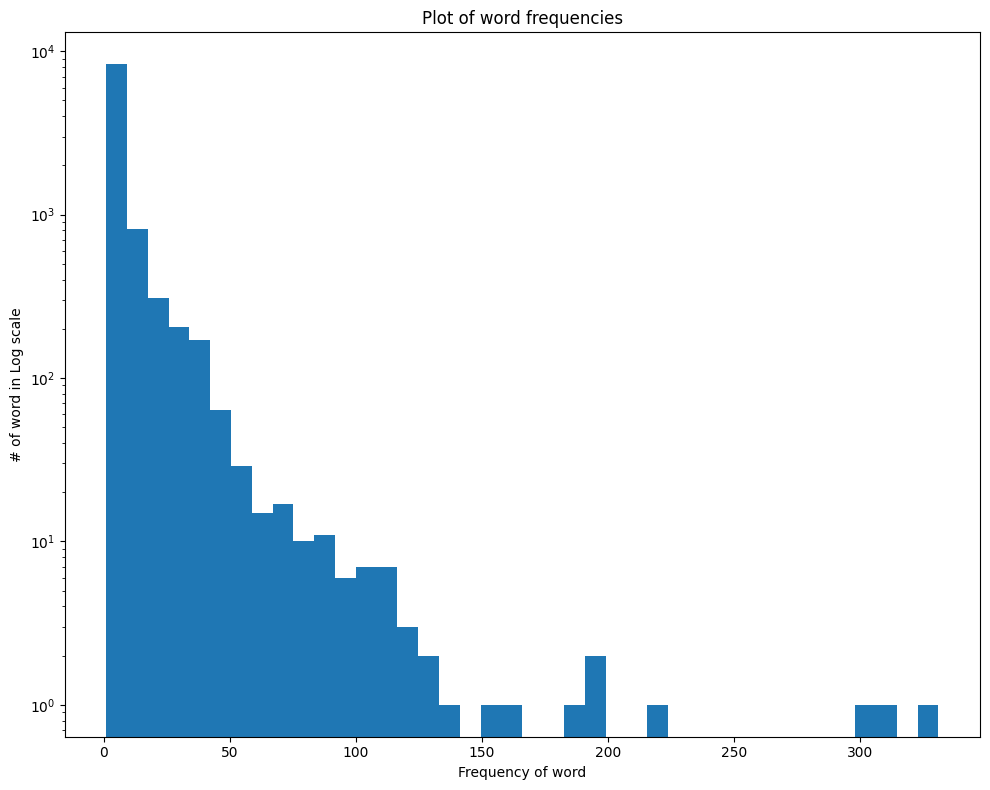

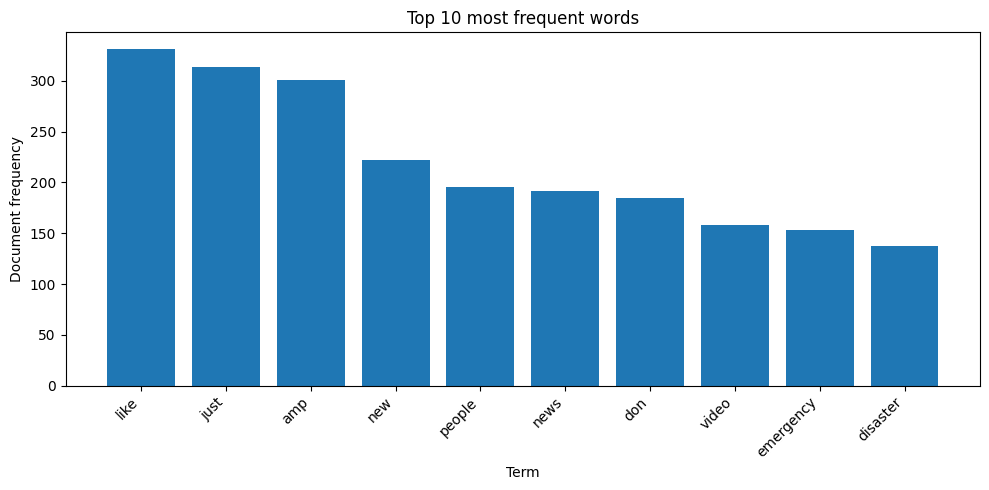

In [103]:

# Frequency of word used plot
plt.figure(figsize=(10,8))
plt.hist(tfidf["freq"], bins=40)
plt.xlabel("Frequency of word")
plt.ylabel("# of word in Log scale")
plt.title("Plot of word frequencies")
plt.yscale("log")
plt.tight_layout()
plt.show()


# Top words Plot
top_words = tfidf.sort_values("freq", ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.bar(top_words["word"], top_words["freq"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Term")
plt.ylabel("Document frequency")
plt.title("Top 10 most frequent words")
plt.tight_layout()
plt.show()






Looking at these plots is a perfect example of why we need to use TF-IDF. TF-IDF converts texts to numerical but it does so that words that are more important to specifc documents or topics are highlighted while words that appear in many documents are given less weight. Our graphs here show that there is a lot of single time used words, but we also have words like "like" and "just" that are used many times, so TF-IDF seems very appropriate. 

TF means term frequency (general count) and IDF is the inverse document score (are words found often or not often in documents) and the score is basic multiplication of TF X IDF

Build and train your sequential neural network model 

In [ ]:



# for our Keras Dense NN we need these matrices
x_dense_training = x_tfidf_training.toarray().astype("float32")
x_dense_val = x_tfidf_val.toarray().astype("float32")
x_dense_test = x_tfidf_test.toarray().astype("float32")

# building the sequential NN but also adding inputs so we can adjust hyperparameters later on
def sequential_nn(input_: int, hidden_units = [128,64], dropout_rate = 0.5, lr = 1e-3) -> tf.keras.Model:
    
    
    model = Sequential()
    model.add(Dense(hidden_units[0], activation = "relu", input_shape = (input_,)))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(loss = "binary_crossentropy", optimizer = Adam(learning_rate = lr), metrics = ["accuracy"])
    
    return model

nn_1 = x_dense_training.shape[1]
nn_model1 = sequential_nn(input_ = nn_1, hidden_units = [128,64], dropout_rate = 0.5, lr = 1e-3)
nn_model1.summary()





/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,257 (4.88 MB)

 Trainable params: 1,280,257 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

Results and Analysis (35 pts)

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.


First were going to test the hyperparameters hidden_units, dropout_rate, and lr (learning rate) with our current model. Then we are going to tune our final model with the best values that we find

In [113]:

def test_hyperparams(X_train, y_train, X_val, y_val, hidden_units, dropout_rate, lr, batch_size = 64, epochs = 10, verbose = 0):
    nn_2 = x_tfidf_training.shape[1]
    nn_model2 = sequential_nn(input_ = nn_2, hidden_units = hidden_units, dropout_rate = dropout_rate, lr = lr)


    early_stopping = EarlyStopping(monitor = "val_loss", patience = 2, restore_best_weights = True)

    learning_rate_reducer = ReduceLROnPlateau(monitor = "val_loss", factor =0.5, patience = 1, min_lr = 1e-5, verbose = 0)
    history = nn_model2.fit(X_train, y_train, validation_data = (X_val, y_val),
                        epochs = epochs, batch_size = batch_size, callbacks = [early_stopping, learning_rate_reducer],
                        verbose = verbose)
    
    validation_loss , validation_accuracy = nn_model2.evaluate(X_val, y_val, verbose = 0)
    y_val_prediction_rate = nn_model2.predict(X_val).ravel()
    y_val_prediction = (y_val_prediction_rate >= 0.5).astype(int)
    f1_value = f1_score(y_val, y_val_prediction)
    
    return nn_model2, history, validation_loss, validation_accuracy, f1_value


In [ ]:
hidden_configs = [[64],[128, 64],[256, 128]]    
dropouts = [0.3, 0.5]
lrs = [1e-3, 5e-4]

results = []
histories = []
models = []

ids = 0
for hidden, dr, lr in product(hidden_configs, dropouts, lrs):
    ids += 1
    print(ids)
    print("hidden_units: ", hidden, "dropout: ", dr, "learning rate: ", lr)
    
    model_cfg, hist_cfg, validation_loss, validation_acc, val_f1 = test_hyperparams(
        x_dense_training, y_train,
        x_dense_val, y_val,
        hidden_units=hidden,
        dropout_rate=dr,
        lr=lr,
        batch_size=64,
        epochs=10,
        verbose=0
    )
    
    models.append(model_cfg)
    histories.append(hist_cfg)
    
    results.append({
        "config_id": ids,
        "hidden_units": str(hidden),
        "dropout": dr,
        "lr": lr,
        "val_loss": validation_loss,
        "val_acc": validation_acc,
        "val_f1": val_f1,
        "epochs_trained": len(hist_cfg.history["loss"])
    })

# Put results into a DataFrame
results = pd.DataFrame(results)
results = results.sort_values("val_f1", ascending=False).reset_index(drop=True)
print("Best Hyperparameter by f1 score:")
print(results)




1
hidden_units:  [64] dropout:  0.3 learning rate:  0.001


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
2
hidden_units:  [64] dropout:  0.3 learning rate:  0.0005


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
3
hidden_units:  [64] dropout:  0.5 learning rate:  0.001


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4
hidden_units:  [64] dropout:  0.5 learning rate:  0.0005


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
5
hidden_units:  [128, 64] dropout:  0.3 learning rate:  0.001


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6
hidden_units:  [128, 64] dropout:  0.3 learning rate:  0.0005


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7
hidden_units:  [128, 64] dropout:  0.5 learning rate:  0.001


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
8
hidden_units:  [128, 64] dropout:  0.5 learning rate:  0.0005


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
9
hidden_units:  [256, 128] dropout:  0.3 learning rate:  0.001


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
10
hidden_units:  [256, 128] dropout:  0.3 learning rate:  0.0005


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
11
hidden_units:  [256, 128] dropout:  0.5 learning rate:  0.001


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
12
hidden_units:  [256, 128] dropout:  0.5 learning rate:  0.0005


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Best Hyperparameter by f1 score:
    config_id hidden_units  dropout      lr  val_loss   val_acc    val_f1  \
0           2         [64]      0.3  0.0005  0.450186  0.799737  0.752234   
1           4         [64]      0.5  0.0005  0.451811  0.799737  0.751020   
2          10   [256, 128]      0.3  0.0005  0.450709  0.799737  0.751020   
3           3         [64]      0.5  0.0010  0.449176  0.795798  0.750601   
4           6    [128, 64]      0.3  0.0005  0.451600  0.796454  0.750403   
5           8    [128, 64]      0.5  0.0005  0.451242  0.796454  0.750403   
6           7    [128, 64]      0.5  0.0010  0.450721  0.798424  0.749796   
7          12   [256, 128]      0.5  0.0005  0.451532  0.792515  0.748006   
8           1         [64]      0.3  0.0010  0.452647  0.793828  0.745543   
9           9   [256, 128]      0.3  0.0010  0.454045  0.790545  0.745004   
10          5    [128, 64]      0.3  0.0010  0.453588  0.792515  0.744750   
11  

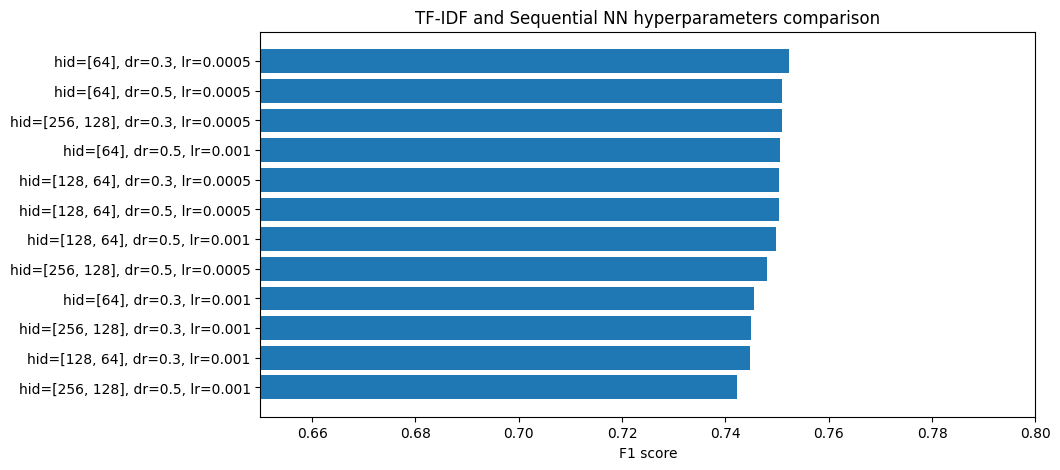

In [124]:
results.sort_values("val_f1", ascending=True)
results["label"] = (
    "hid=" + results["hidden_units"]
    + ", dr=" + results["dropout"].astype(str)
    + ", lr=" + results["lr"].astype(str)
)

plt.figure(figsize=(10,5))
plt.barh(results["label"], results["val_f1"])
plt.xlabel("F1 score")
plt.xlim(0.65, 0.80)
plt.title("TF-IDF and Sequential NN hyperparameters comparison")
plt.gca().invert_yaxis()
plt.show()


Best config:
 config_id                                   2
hidden_units                             [64]
dropout                                   0.3
lr                                     0.0005
val_loss                             0.450186
val_acc                              0.799737
val_f1                               0.752234
epochs_trained                              8
label             hid=[64], dr=0.3, lr=0.0005
Name: 0, dtype: object


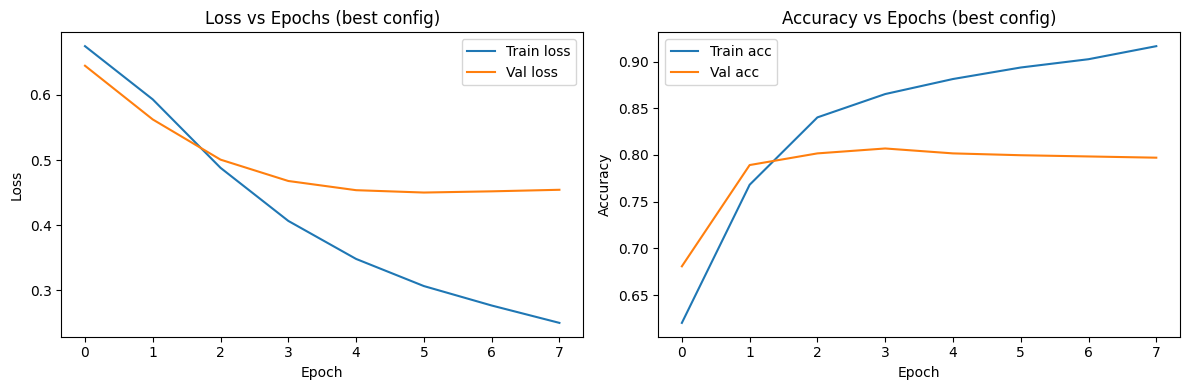

In [ ]:
best_row = results.iloc[0]
best_id = best_row["config_id"]
print("Best config: ", best_row)


best_history = histories[best_id - 1]
best_model = models[best_id - 1]

hist = best_history.history

plt.figure(figsize=(12,4))

# val loss curves
plt.subplot(1,2,1)
plt.plot(hist["loss"], label="Train loss")
plt.plot(hist["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Val Loss against Epochs (best config)")
plt.legend()

# Validation Accuracy 
plt.subplot(1,2,2)
plt.plot(hist["accuracy"], label="Train acc")
plt.plot(hist["val_accuracy"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy vs Epochs (best config)")
plt.legend()

plt.tight_layout()
plt.show()


From these plots testing our hyperparameters hidden_units, dropout, learning rate, we can see that our best hyperparameters are 

hidden unit: 64
dropout: 0.3
learning rate: 0.0005

and these gave us a f1 score of 0.752234 and a validation accuracy of 0.799737

Our TF-IDF most likely liked a shallow network of hidden_unit =64 and dropout = 0.3 as it usually works better in a smaller network. We also see that after epoch 2 that there the validation accuracy and validation loss settles down in value a lot meaining that up to epoch 2 is where were getting most value. We also had a pretty low learning rate of 0.0005 this is probably because larger learning rates cause overshooting and our model training is much more smooth this way. 

Now we are going to train our model again with the best hyperparameters

In [131]:
best_hidden_units   = [64]

best_dropout  = 0.3

best_lr       = 5e-4  

# remake sequential NN model with best hyperparameters
input_best = x_dense_training.shape[1]
best_model = sequential_nn(
    input_ = input_best,
    hidden_units = best_hidden_units,
    dropout_rate = best_dropout,
    lr = best_lr
)

best_model.summary()
# Plug in from what we did early
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

learning_rate_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=1,
    min_lr=1e-5,
    verbose=1
)

history_best = best_model.fit(
    x_dense_training, y_train,
    validation_data=(x_dense_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping, learning_rate_reducer],
    verbose=1
)

/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,129 (2.44 MB)

 Trainable params: 640,129 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6158 - loss: 0.6722 - val_accuracy: 0.6697 - val_loss: 0.6409 - learning_rate: 5.0000e-04
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7542 - loss: 0.5880 - val_accuracy: 0.7866 - val_loss: 0.5604 - learning_rate: 5.0000e-04
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8402 - loss: 0.4838 - val_accuracy: 0.8011 - val_loss: 0.5004 - learning_rate: 5.0000e-04
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8672 - loss: 0.4024 - val_accuracy: 0.7991 - val_loss: 0.4684 - learning_rate: 5.0000e-04
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8837 - loss: 0.3460 - val_accuracy: 0.7997 - val_loss: 0.4547 - learning_rate: 5.0000e-04
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8903 - loss: 0.3074 - val_accuracy: 0.7938 - val_loss: 0.4524 - learning_rate: 5.0000e-04
Epoch 7/10
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9060 - loss

Let's quickly evaluate our new model on the validation set

In [133]:
val_loss, val_acc = best_model.evaluate(x_dense_val, y_val, verbose=0)
print("Validation Loss: ", val_loss)
print("Validation Accuracy: ", val_acc)

val_pred_prob = best_model.predict(x_dense_val).ravel()
val_pred = (val_pred_prob >= 0.5).astype(int)

val_f1 = f1_score(y_val, val_pred)
print("f1 Score: ", val_f1)


Validation Loss:  0.45244741439819336
Validation Accuracy:  0.7938279509544373
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
f1 Score:  0.747588424437299


Now finally we are going to retrain on the full training data with our new model with the best hyperparameters

In [134]:
x_dense_full = x_tfidf.toarray().astype("float32")

# Full training on a new model
best_model_full = sequential_nn(
    input_ = x_dense_full.shape[1],
    hidden_units = best_hidden_units,
    dropout_rate = best_dropout,
    lr = best_lr
)

history_best_full = best_model_full.fit(
    x_dense_full, y,
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping, learning_rate_reducer],
    verbose=1
)

# run prediction using the given test set
test_pred_prob = best_model_full.predict(x_dense_test).ravel()
test_pred = (test_pred_prob >= 0.5).astype(int)


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6418 - loss: 0.6680 - learning_rate: 5.0000e-04
Epoch 2/10
 31/119 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7776 - loss: 0.6015

/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:171: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7994 - loss: 0.5602 - learning_rate: 5.0000e-04
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8508 - loss: 0.4488 - learning_rate: 5.0000e-04
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8679 - loss: 0.3762 - learning_rate: 5.0000e-04
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8797 - loss: 0.3296 - learning_rate: 5.0000e-04
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8899 - loss: 0.2969 - learning_rate: 5.0000e-04
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9011 - loss: 0.2692 - learning_rate: 5.0000e-04
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9088 - loss: 0.2467 - learning_rate: 5.0000e-04
Epoch 9/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9141 - loss: 0.2288 - learning_rate: 5.0000e-04
Epoch 10/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9247 - loss: 0.2118 - learning_r

Now we make a csv for kaggle submission 

In [135]:
submission = pd.DataFrame({
    "id": testing["id"],
    "target": test_pred
})

submission.to_csv("submission_best_hyperparams.csv", index=False)


Conclusion:
Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

In my projecct I explored different modeling strategies using TF-IDF and Sequential Neural Networks(Dense) in order to classify diaster related tweets. What worked well for me was that TF-IDF was a good model to choose because tweets by design are short and this helped my model run fast and accurate without sacrificing as much runtime than other heavier methods I could have used. My hyperparameter tuning also worked very well, and I was able to get good results for the hyperparameters and tune my final model to its best ability. I also implemented a early stoping and learning rate scheduling in order to stop overfitting when we increased epochs. 

A couple things that did not help was that the TF-IDF model as we increased the hidden value higher our f1 score didnt really improve as much as I thought it would. Although, my accuracy score was good, because the f1 value didn't get much higher I suspect that I had some overfitting on those larger ones. Because I implemented the early stopping I could see some of my model not improving after they reached the 5 epoch mark, and increasing the epochs made my results have worse validation and I believe this would be overfitting as well. 

For future improvements I would say trying a more advanced NLP would be interesting and comparing it to my TF-IDF Dense NN system I made. Also, not using Dense but another neural network system woudl be interesting to see if there would be improvement or not. And then because this was about tweets specifically, it would be interesting if I could handle things like hashtags or maybe popular users' or accounts' usernames. Like if disasters happen are people likely to tag the national guard account or their senator or mayor. 


References:
TF-IDF
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

Dense NN Keras
https://keras.io/api/layers/core_layers/dense/

vectorizier
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html